In [1]:
import arviz as az
import geopandas as gpd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.preprocessing import LabelEncoder

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=0)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
plz_df: gpd.GeoDataFrame = gpd.read_file("../data/kitas_data.geojson")

plz_df = plz_df.sort_values(by=["district", "plz"])

plz_df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 214 entries, 46 to 213
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   plz                   214 non-null    object  
 1   einwohner             214 non-null    int64   
 2   district              214 non-null    object  
 3   num_kitas_plz         214 non-null    int64   
 4   spots_plz             214 non-null    float64 
 5   num_kitas_plz_pc      214 non-null    float64 
 6   num_kitas_plz_pc_log  214 non-null    float64 
 7   geometry              214 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(2)
memory usage: 15.0+ KB


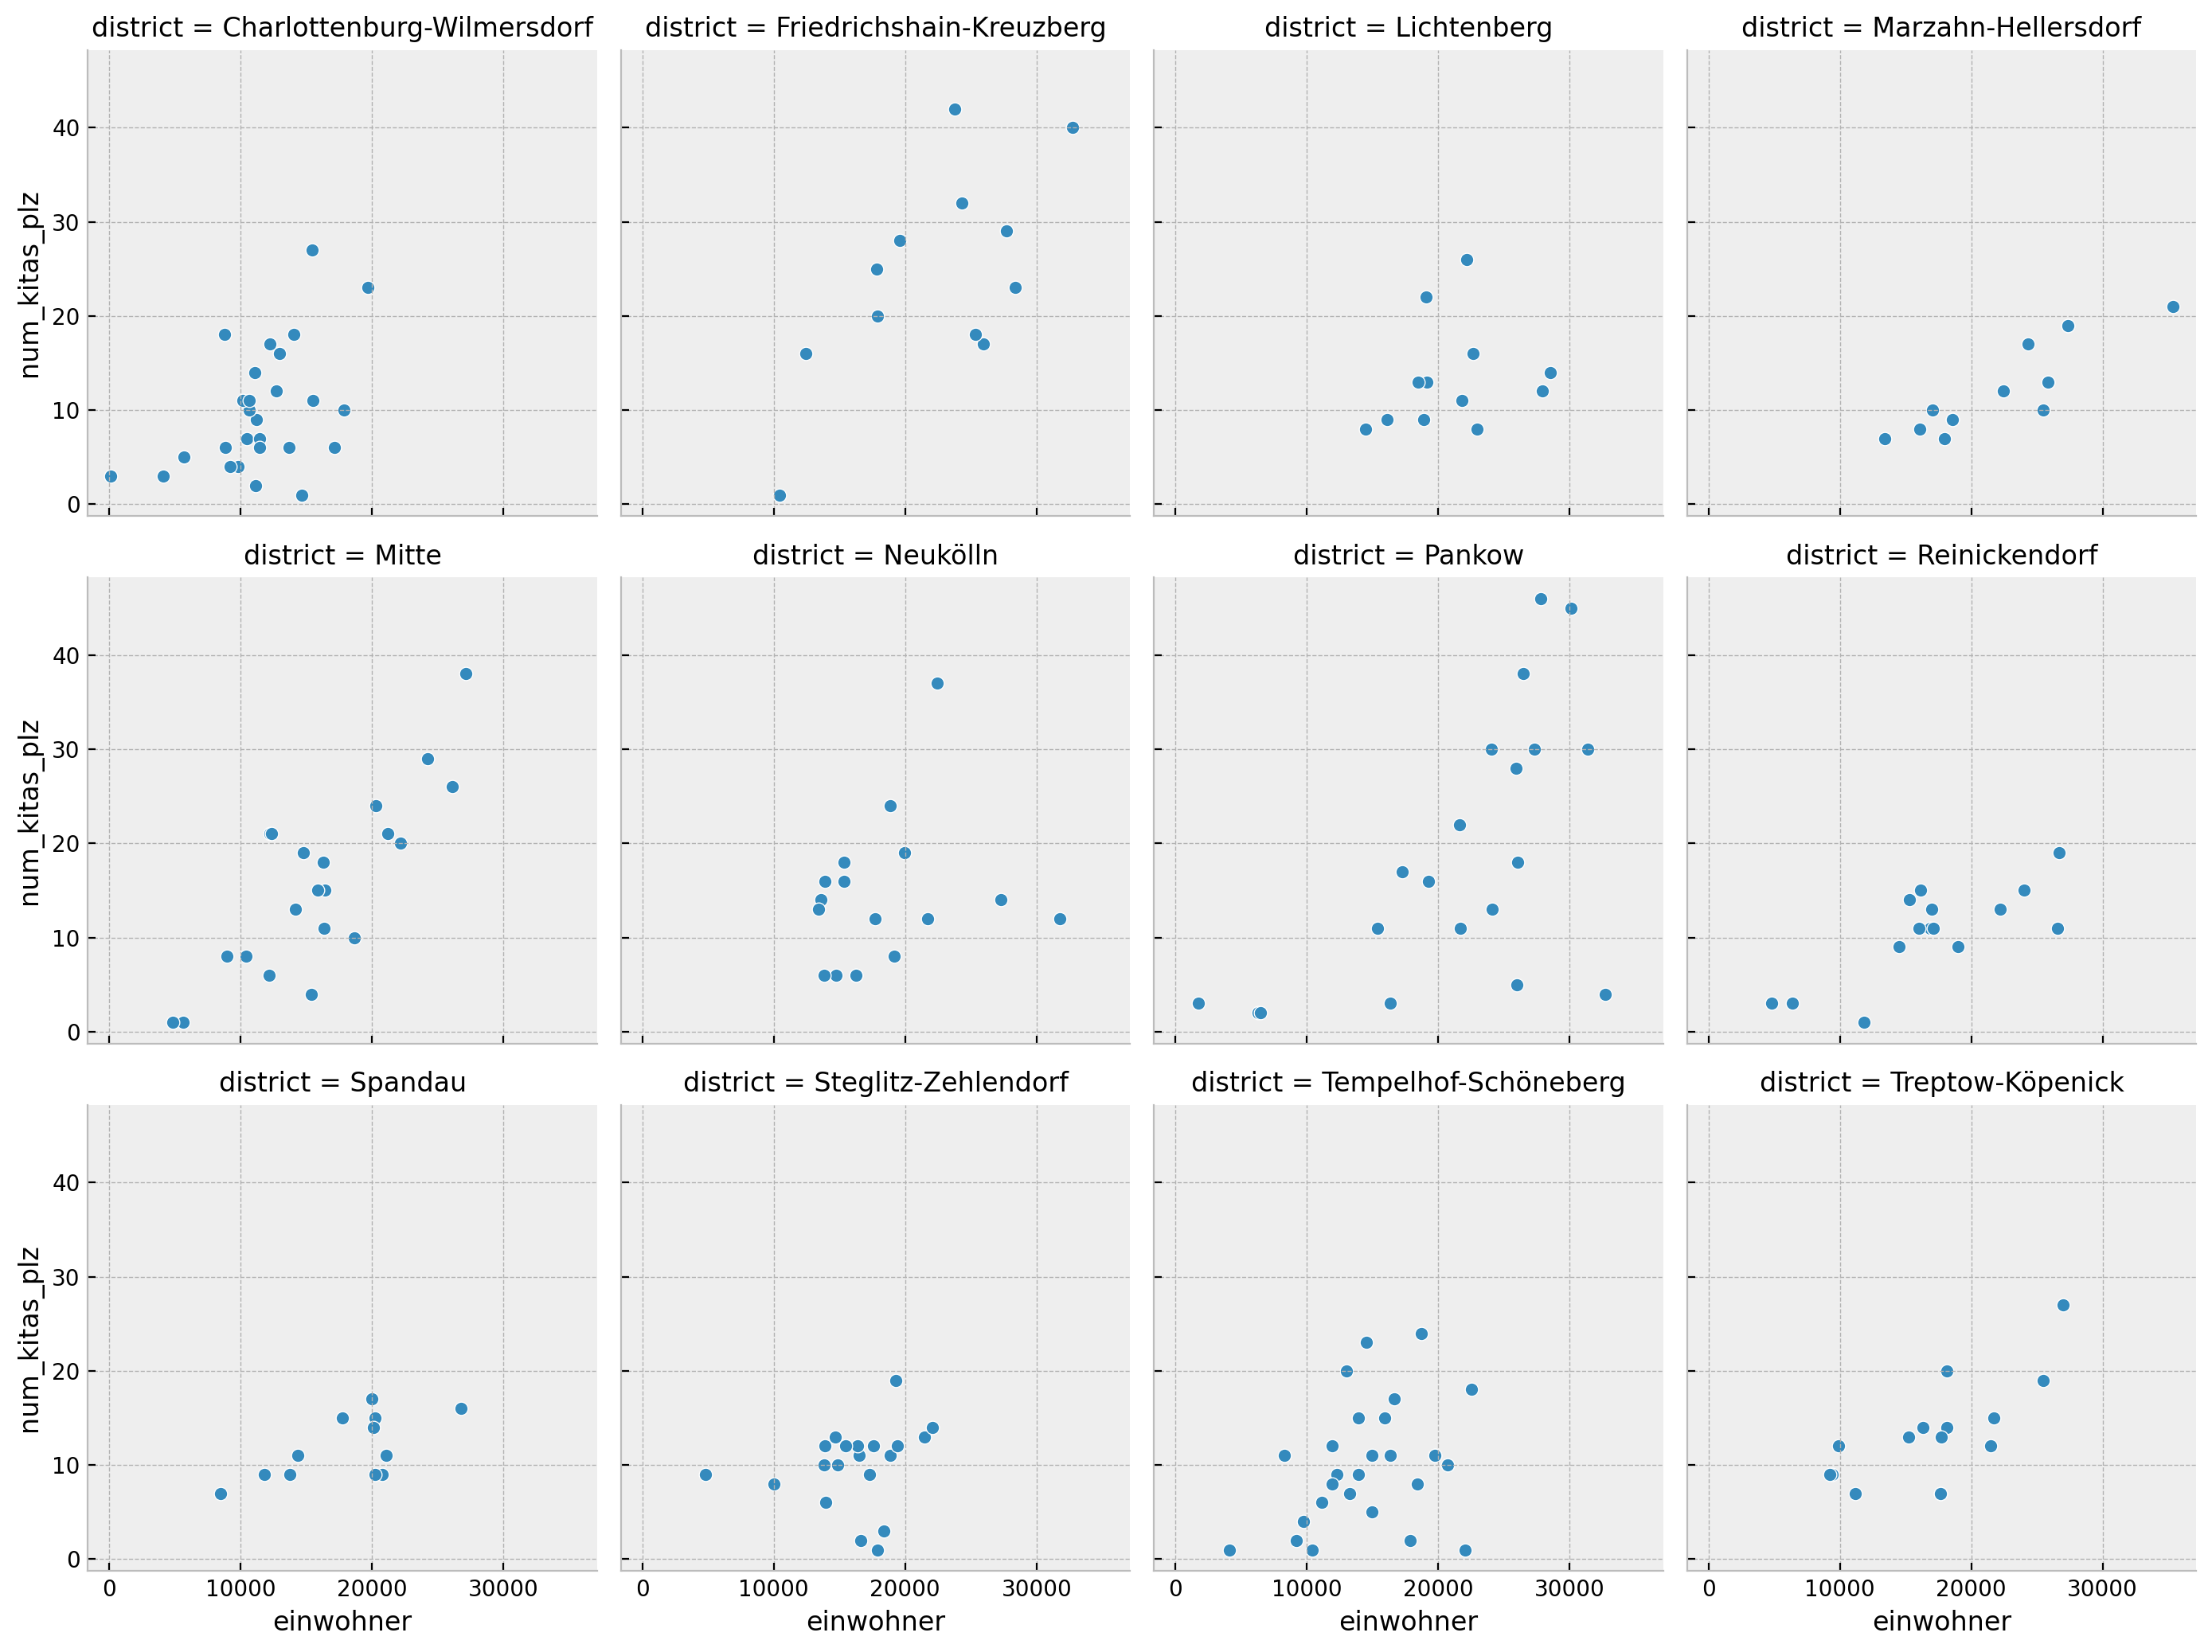

In [16]:
g = sns.relplot(
    data=plz_df,
    x="einwohner",
    y="num_kitas_plz",
    col="district",
    col_wrap=4,
    height=3.5,
    aspect=1,
)

In [4]:
num_kitas_plz = jnp.array(plz_df["num_kitas_plz"].to_numpy())

einwohner = jnp.array(plz_df["einwohner"].to_numpy() / 1e4)

districts_encoder = LabelEncoder()
districts = districts_encoder.fit_transform(plz_df["district"])


In [5]:
def model(
    einwohner: ArrayImpl, districts: ArrayImpl, num_kitas_plz: ArrayImpl | None = None
) -> None:
    intercept_loc = numpyro.sample(name="intercept_loc", fn=dist.Normal(loc=0, scale=1))
    intercept_scale = numpyro.sample(
        name="intercept_scale", fn=dist.HalfCauchy(scale=10)
    )
    slope_loc = numpyro.sample(name="slope_loc", fn=dist.Normal(loc=0, scale=1))
    slope_scale = numpyro.sample(name="slope_scale", fn=dist.HalfCauchy(scale=10))

    concentration_tilde = numpyro.sample(
        name="concentration_tilde", fn=dist.HalfCauchy(scale=10)
    )
    concentration = numpyro.deterministic(
        name="concentration", value=1 / jnp.square(concentration_tilde)
    )

    n_districts = np.unique(districts).size

    with numpyro.plate(name="districts", size=n_districts):
        intercept_district = numpyro.sample(
            name="intercept_district",
            fn=dist.Normal(loc=intercept_loc, scale=intercept_scale),
        )
        slope_district = numpyro.sample(
            name="slope_district", fn=dist.Normal(loc=slope_loc, scale=slope_scale)
        )

    mu = numpyro.deterministic(
        name="mu",
        value=jnp.exp(
            intercept_district[districts] + slope_district[districts] * einwohner
        ),
    )

    n_obs: int = einwohner.size

    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(
            name="obs",
            fn=dist.NegativeBinomial2(
                mean=mu,
                concentration=concentration,
            ),
            obs=num_kitas_plz,
        )


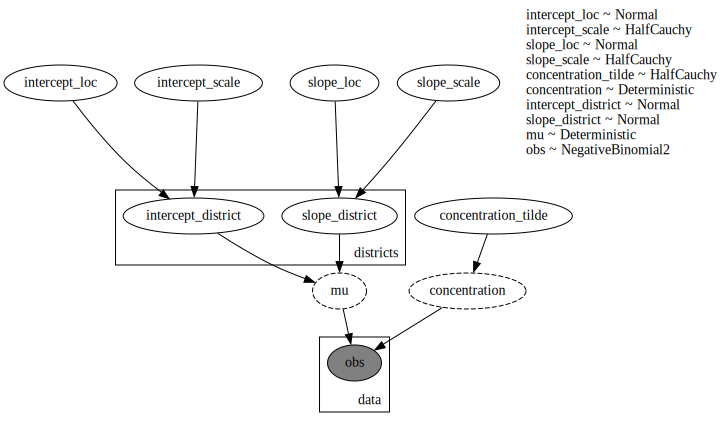

In [6]:
numpyro.render_model(
    model=model,
    model_args=(einwohner, districts, num_kitas_plz),
    render_distributions=True,
    render_params=True,
)


In [7]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "intercept_district": LocScaleReparam(0),
    "slope_district": LocScaleReparam(0),
}

reparam_model = reparam(fn=model, config=reparam_config)


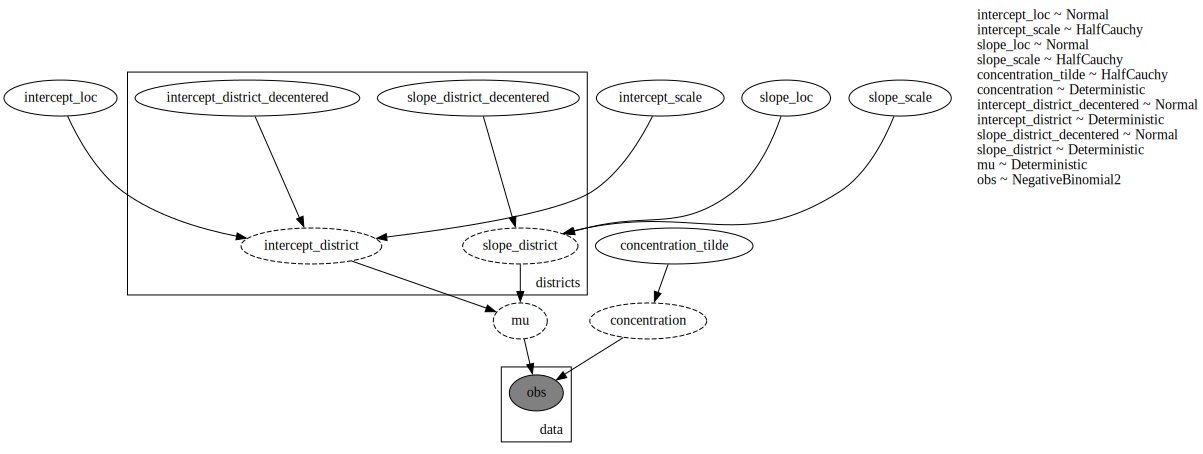

In [8]:
numpyro.render_model(
    model=reparam_model,
    model_args=(einwohner, districts, num_kitas_plz),
    render_distributions=True,
    render_params=True,
)


In [9]:
# set sampler
nuts_kernel = NUTS(model=reparam_model, target_accept_prob=0.95)
mcmc = MCMC(sampler=nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4)
# run sampler
rng_key, rng_subkey = random.split(key=rng_key)
mcmc.run(rng_subkey, einwohner, districts, num_kitas_plz)
# get posterior samples
posterior_samples = mcmc.get_samples()
# get posterior predictive samples
posterior_predictive = Predictive(
    model=reparam_model, posterior_samples=posterior_samples
)
rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, einwohner, districts)
# convert to arviz inference data object
idata = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictive_samples,
    coords={"districts": districts_encoder.classes_, "plz": plz_df["plz"].to_numpy()},
    dims={
        "intercept_district": ["districts"],
        "slope_district": ["districts"],
        "intercept_district_decentered": ["districts"],
        "slope_district_decentered": ["districts"],
        "mu": ["plz"],
        "obs": ["plz"],
    },
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [10]:
az.summary(data=idata, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
concentration,6.174,1.004,4.336,8.003,0.007,0.005,21886.0,10381.0,1.0
concentration_tilde,0.406,0.033,0.347,0.469,0.000,0.000,21886.0,10381.0,1.0
intercept_district[Charlottenburg-Wilmersdorf],1.439,0.128,1.200,1.685,0.001,0.001,15028.0,12249.0,1.0
intercept_district[Friedrichshain-Kreuzberg],1.481,0.164,1.172,1.794,0.002,0.001,10531.0,9768.0,1.0
intercept_district[Lichtenberg],1.388,0.158,1.085,1.686,0.001,0.001,12102.0,11624.0,1.0
intercept_district[Marzahn-Hellersdorf],1.338,0.175,1.003,1.659,0.002,0.001,7926.0,9486.0,1.0
intercept_district[Mitte],1.460,0.144,1.198,1.746,0.001,0.001,12106.0,12274.0,1.0
intercept_district[Neukölln],1.438,0.147,1.154,1.710,0.001,0.001,13581.0,11146.0,1.0
intercept_district[Pankow],1.395,0.151,1.108,1.677,0.001,0.001,14485.0,12502.0,1.0
intercept_district[Reinickendorf],1.364,0.154,1.075,1.657,0.001,0.001,10728.0,11117.0,1.0


In [11]:
idata["sample_stats"]["diverging"].sum().item()

0

Text(0.5, 0.98, 'Model Trace')

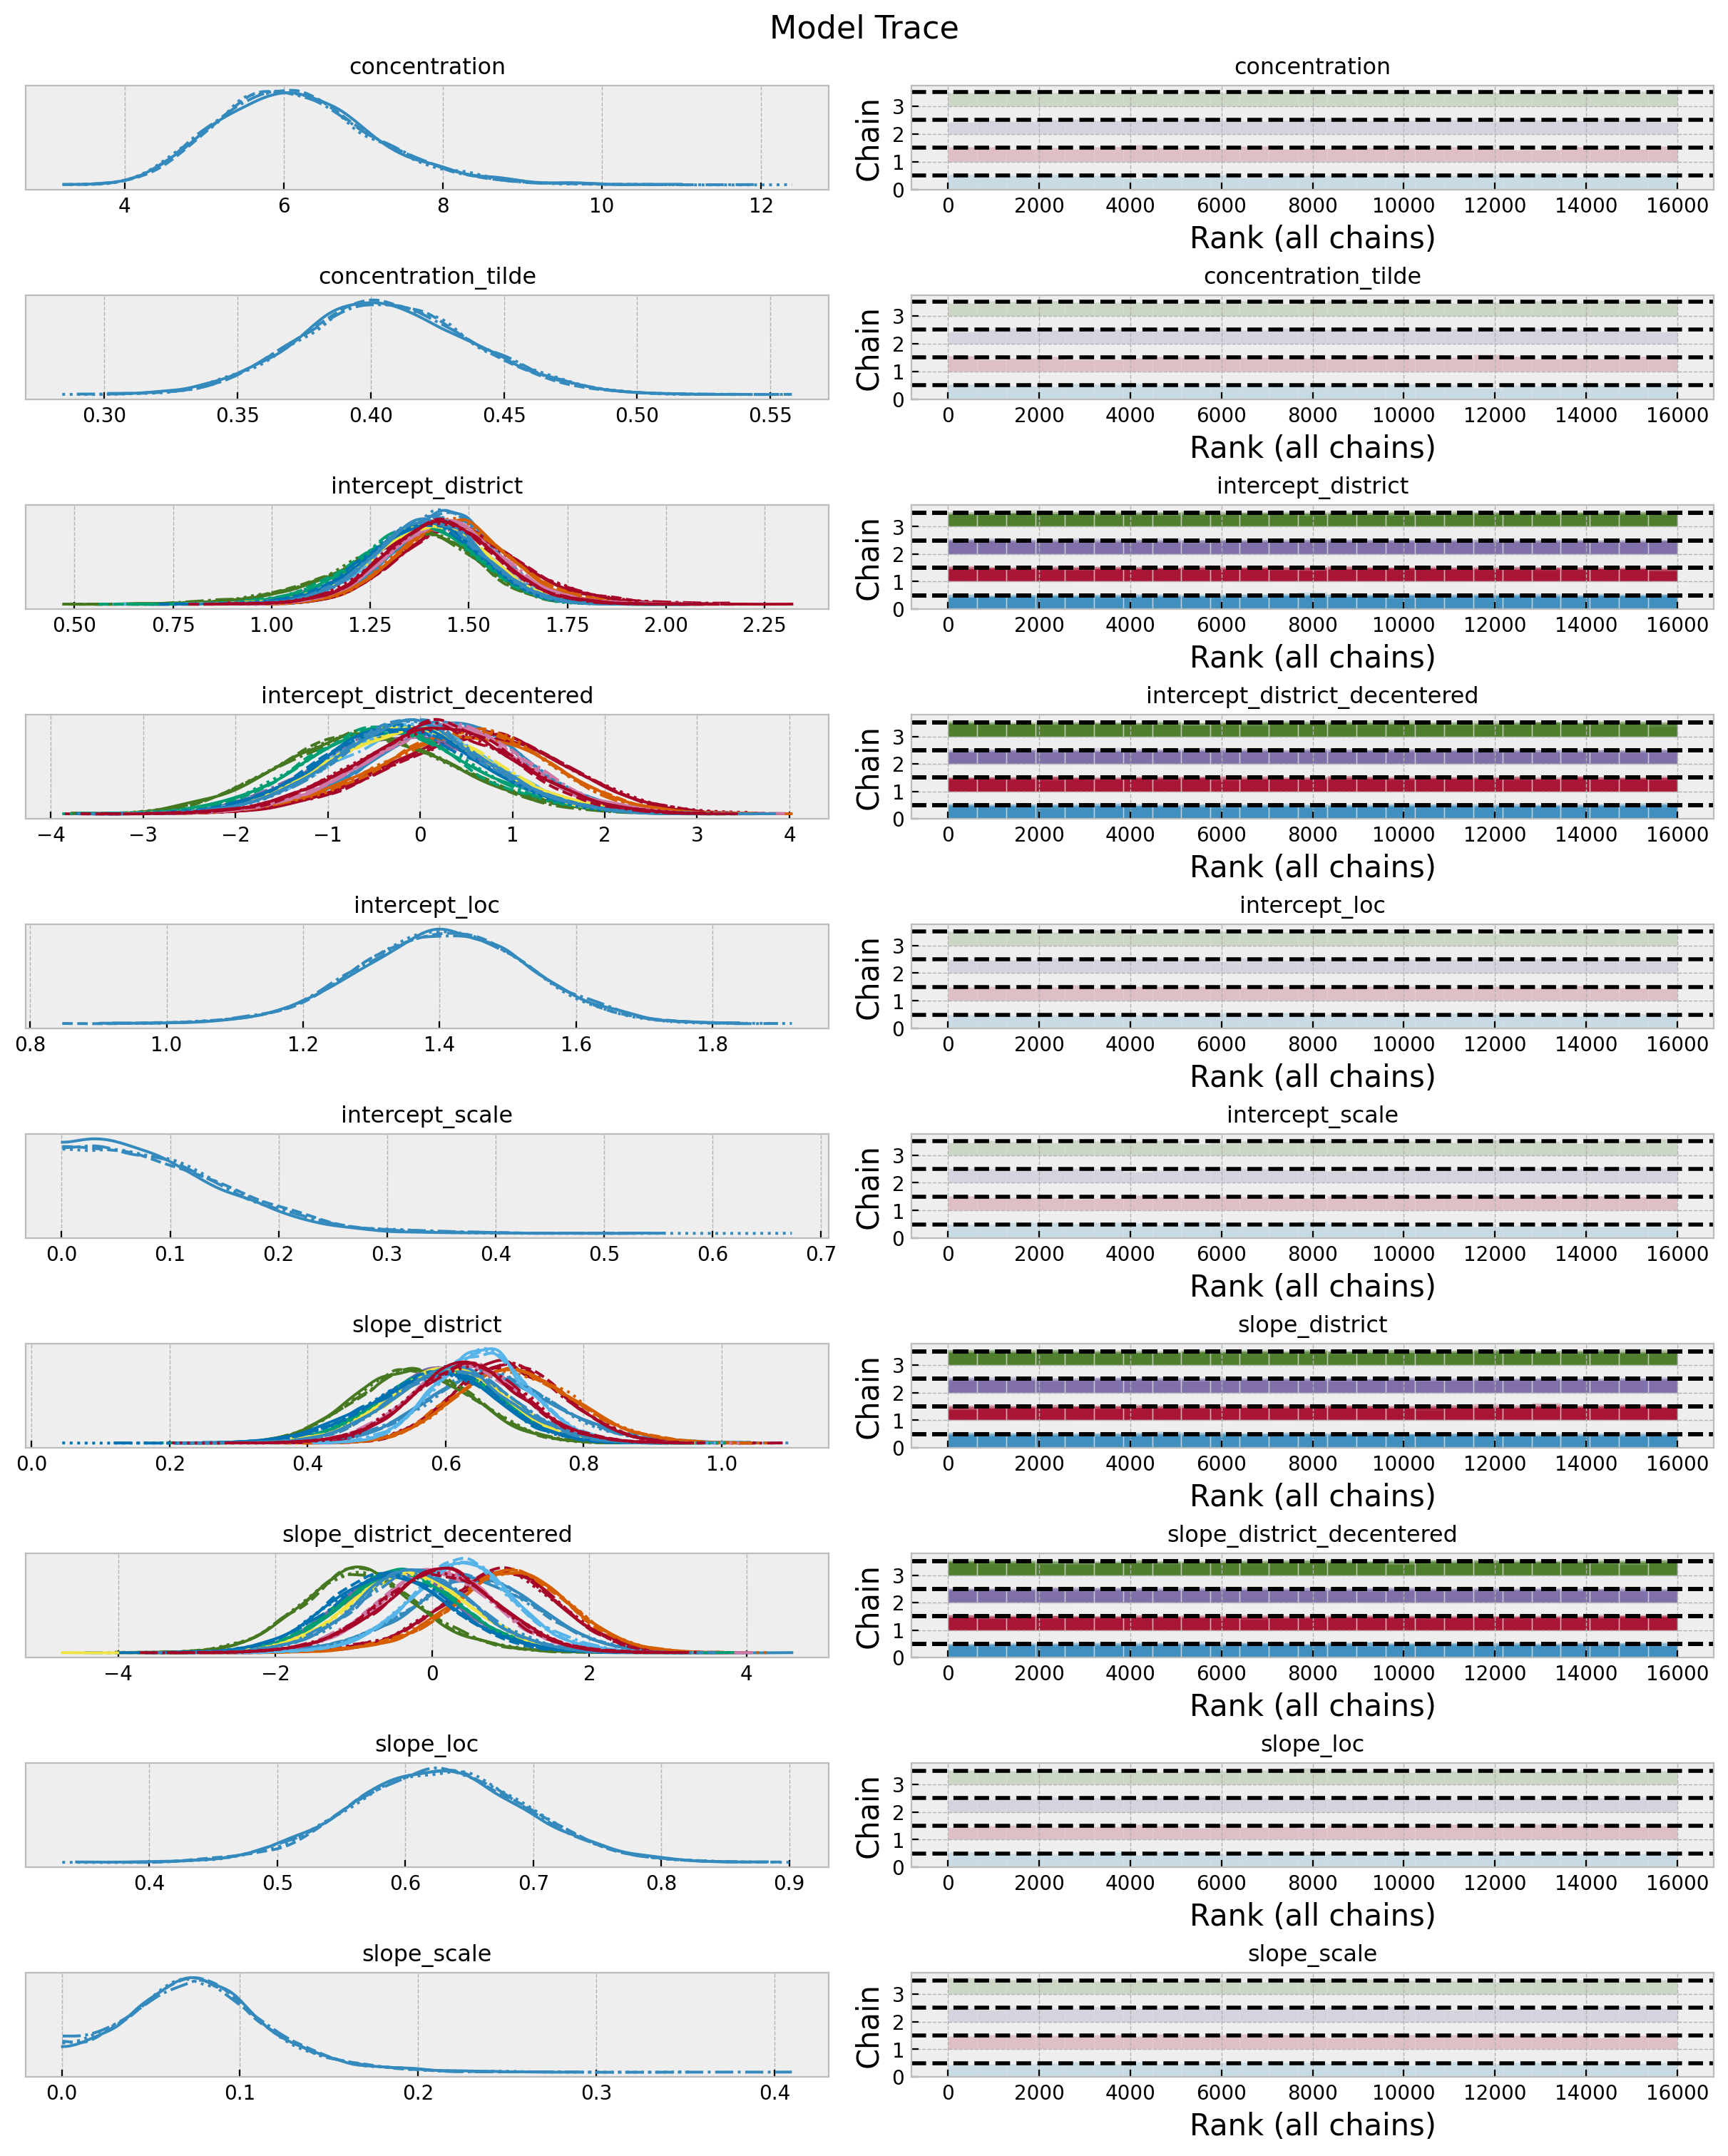

In [12]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)


In [13]:
plz_df["num_kitas_plz_pred_mean"] = idata["posterior_predictive"]["obs"].mean(
    dim=["chain", "draw"]
)
plz_df["num_kitas_plz_pred_q025"] = idata["posterior_predictive"]["obs"].quantile(
    dim=["chain", "draw"], q=0.025
)
plz_df["num_kitas_plz_pred_q975"] = idata["posterior_predictive"]["obs"].quantile(
    dim=["chain", "draw"], q=0.975
)


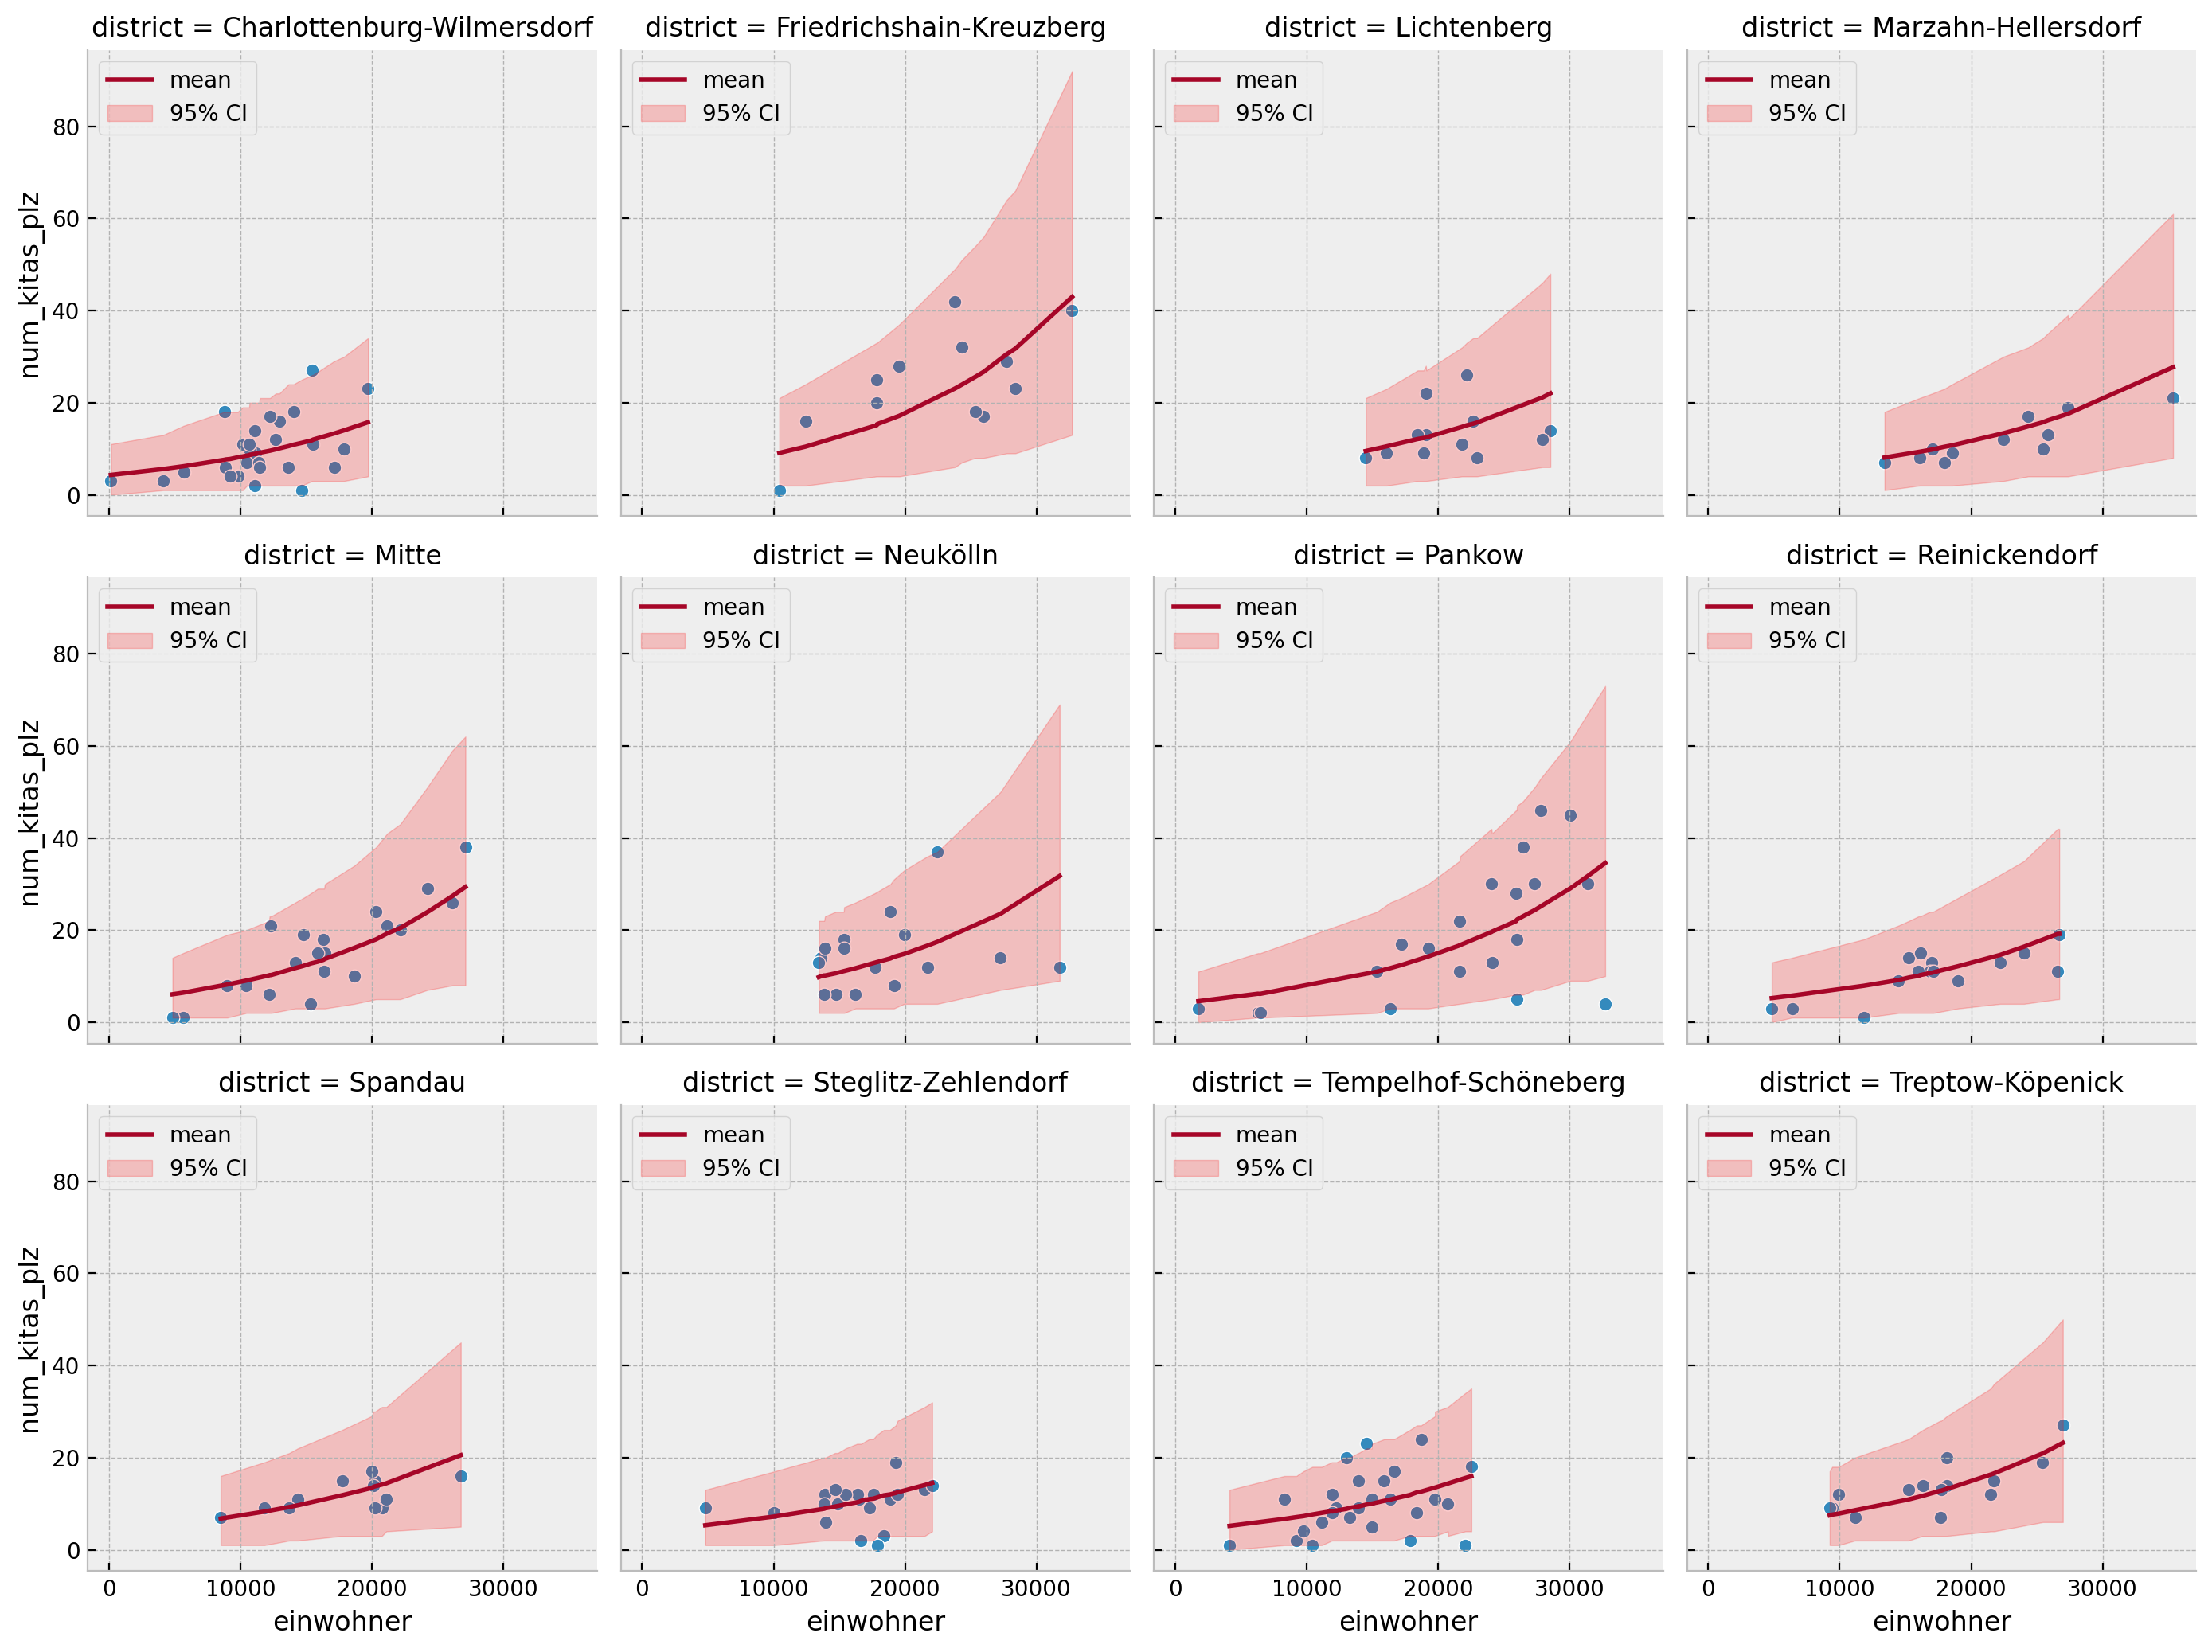

In [14]:
g = sns.relplot(
    data=plz_df,
    x="einwohner",
    y="num_kitas_plz",
    color="C0",
    col="district",
    col_wrap=4,
    height=3.5,
    aspect=1,
)

for district, ax in g.axes_dict.items():
    district_df = plz_df.query("district == @district").sort_values(by="einwohner")

    sns.lineplot(
        data=district_df,
        x="einwohner",
        y="num_kitas_plz_pred_mean",
        color="C1",
        label="mean",
        ax=ax,
    )

    ax.fill_between(
        x=district_df["einwohner"],
        y1=district_df["num_kitas_plz_pred_q025"],
        y2=district_df["num_kitas_plz_pred_q975"],
        color="red",
        alpha=0.2,
        label="95% CI",
    )
    ax.legend(loc="upper left")


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

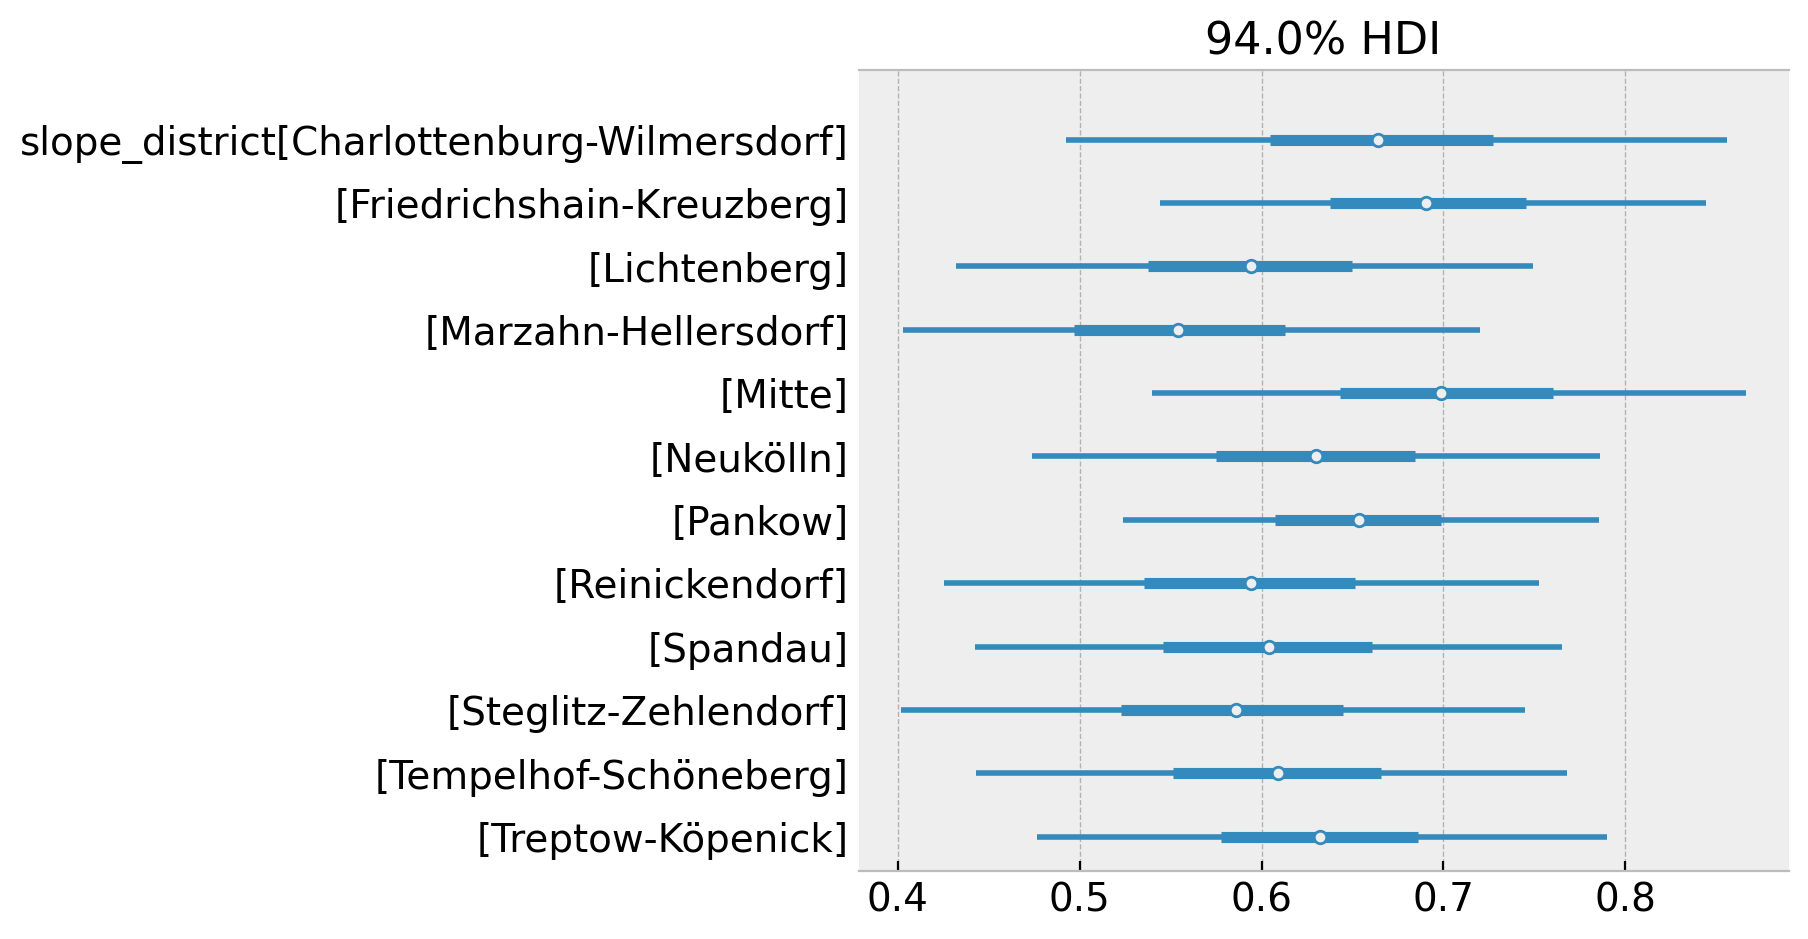

In [18]:
az.plot_forest(data=idata, var_names=["slope_district"], combined=True)